In [25]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

In [26]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    print("Missing values in each column:\n", df.isnull().sum())
    df.hist(figsize=(15, 10))
    plt.show()
    return df

In [27]:
# Function to train the Random Forest model
def train_random_forest(df):
    le = LabelEncoder()
    df["Celestial Body"] = le.fit_transform(df["Celestial Body"])

    # Select features and target variable
    x = df.iloc[:, 1:-1]  # Adjust according to your dataframe
    y = df.iloc[:, -1]

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42
    )

    # Initialize and train the Random Forest model
    r = RandomForestClassifier(n_estimators=100, random_state=1)
    r.fit(x_train, y_train)

    # Print feature names for debugging
    print("Features used for training:\n", x.columns.tolist())

    y_pred = r.predict(x_test)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

    save_model(r, "RF_mining_model.pkl")
    return r

In [28]:
# Function to save the trained model
def save_model(model, model_name):
    save_dir = "C:\\imp\\1. ISRO"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    joblib.dump(model, model_path)
    print(f"Model saved at: {model_path}")

In [29]:
# Function to test the Random Forest model
def test_random_forest_model(model):
    # Ensure that the feature names match those used during training
    feature_columns = [
        "Distance from Earth (M km)",
        "Iron (%)",
        "Nickel (%)",
        "Water Ice (%)",
        "Other Minerals (%)",
        "Estimated Value (B USD)",
        "Sustainability Index",
        "Efficiency Index",
    ]

    print("Model expected feature columns:\n", feature_columns)

    # Prepare input data for predictions
    input_data_1 = pd.DataFrame(
        [
            [
                413.95896411015195,
                12.031864299982333,
                4.860503665226579,
                16.003773827097444,
                67.10385820769365,
                36.13170667717836,
                70.128135040172,
                98.46379316404845,
            ]
        ],
        columns=feature_columns,
    )

    print("Input Data 1:\n", input_data_1)  # Debugging print
    print("Shape of Input Data 1:", input_data_1.shape)  # Debugging print

    try:
        prediction_1 = model.predict(input_data_1)
        print("Prediction for first input data:", prediction_1)
    except ValueError as e:
        print("ValueError during prediction:", e)

    input_data_2 = pd.DataFrame(
        [
            [
                262.8905503798111,
                6.388814509817609,
                1.3821046270023083,
                11.568467371683752,
                80.66061349149633,
                31.054831518801926,
                25.13901985443363,
                89.44942857312876,
            ]
        ],
        columns=feature_columns,
    )

    print("Input Data 2:\n", input_data_2)  # Debugging print
    print("Shape of Input Data 2:", input_data_2.shape)  # Debugging print

    try:
        prediction_2 = model.predict(input_data_2)
        print("Prediction for second input data:", prediction_2)
    except ValueError as e:
        print("ValueError during prediction:", e)

In [30]:
# Simple Neural Network Model Class
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [31]:
# Function to train the PyTorch model
def train_pytorch_model(df):
    le = LabelEncoder()
    df["Celestial Body"] = le.fit_transform(df["Celestial Body"])

    # Select features and target variable
    x = df.iloc[:, 1:-1].values.astype(np.float32)  # Convert to float32
    y = df.iloc[:, -1].values.astype(np.int64)  # Convert to int64

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42
    )

    # Convert to PyTorch tensors
    x_train_tensor = torch.tensor(x_train)
    y_train_tensor = torch.tensor(y_train)
    x_test_tensor = torch.tensor(x_test)
    y_test_tensor = torch.tensor(y_test)

    # Create DataLoader
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Define model, loss function, and optimizer
    input_size = x.shape[1]
    hidden_size = 64
    output_size = len(np.unique(y))  # Number of unique classes

    model = SimpleNN(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 100
    for epoch in range(num_epochs):
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    print("Training complete.")

    # Test the model and print accuracy
    with torch.no_grad():
        model.eval()  # Set model to evaluation mode
        test_outputs = model(x_test_tensor)
        _, predicted = torch.max(test_outputs, 1)
        accuracy = (predicted.numpy() == y_test).mean()
        print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Save the model
    save_pytorch_model(model, "pytorch_model.pth")

In [32]:
# Function to save the trained PyTorch model
def save_pytorch_model(model, model_name):
    save_dir = "C:\\imp\\1. ISRO"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model_path = os.path.join(save_dir, model_name)
    torch.save(model.state_dict(), model_path)
    print(f"PyTorch model saved at: {model_path}")

Missing values in each column:
 Celestial Body             0
distance_from_earth        0
iron                       0
nickel                     0
water_ice                  0
other_minerals             0
Estimated Value (B USD)    0
sustainability_index       0
efficiency_index           0
Potential Mining Site      0
dtype: int64


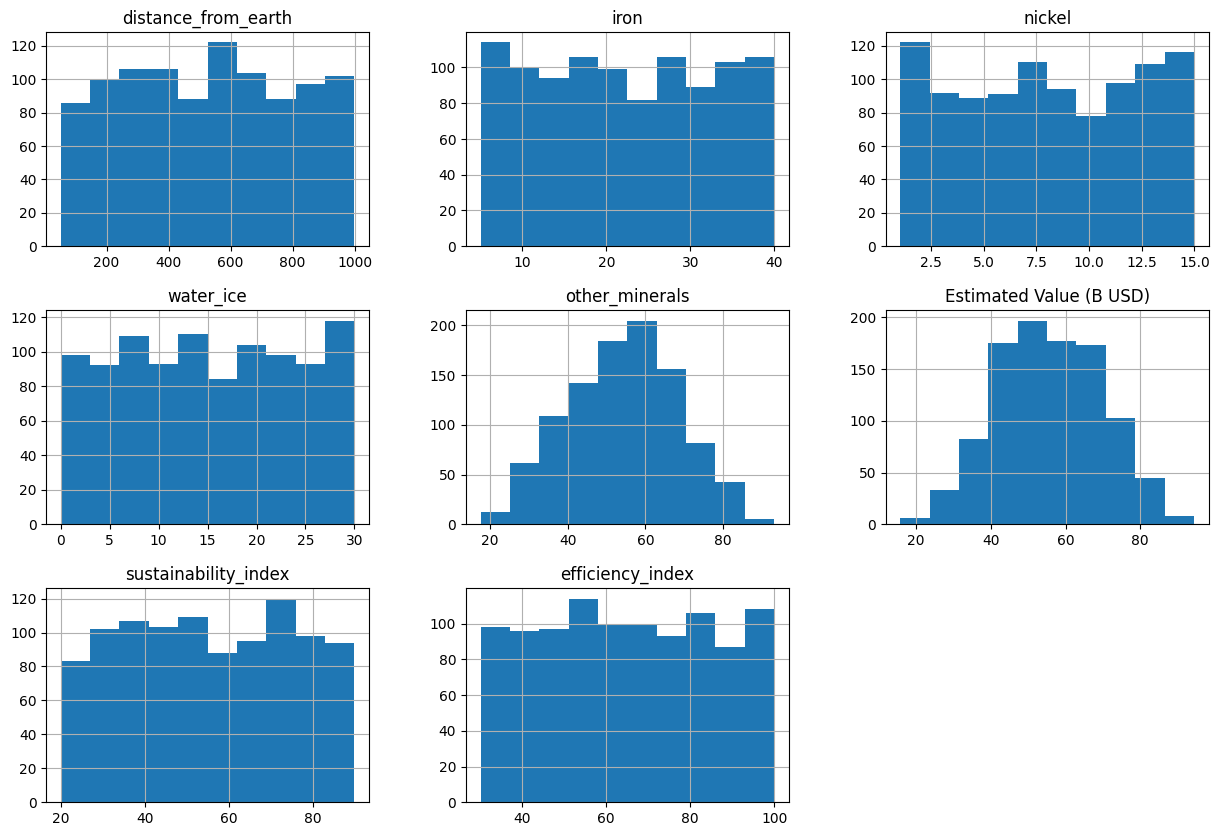

Features used for training:
 ['distance_from_earth', 'iron', 'nickel', 'water_ice', 'other_minerals', 'Estimated Value (B USD)', 'sustainability_index', 'efficiency_index']
Confusion Matrix:
 [[136   0]
 [  0  64]]

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       136
        True       1.00      1.00      1.00        64

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Accuracy Score: 1.0
Model saved at: C:\imp\1. ISRO\RF_mining_model.pkl
Model expected feature columns:
 ['Distance from Earth (M km)', 'Iron (%)', 'Nickel (%)', 'Water Ice (%)', 'Other Minerals (%)', 'Estimated Value (B USD)', 'Sustainability Index', 'Efficiency Index']
Input Data 1:
    Distance from Earth (M km)   Iron (%)  Nickel (%)  Water Ice (%)  \
0                  413.958964  12.031864    4.860504      16.003774   

   

In [33]:
def main():
    df = load_data("space_mining_dataset.csv")
    rf_model = train_random_forest(df)
    test_random_forest_model(rf_model)
    train_pytorch_model(df)  # Train the PyTorch model


if __name__ == "__main__":
    main()